In [1]:
# activate inline plotting
%matplotlib inline
from setup import *

# Heritability Estimation

This tutorial demonstrates how genotype data can be used to generate simulated phenotpye datasetes.

#### 1000 Genomes

In [2]:
#load 1000 genomes data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
genotype_file = tutorial_data.get_file('1000g')
annotation_file = tutorial_data.get_file('1000g_annotation')
geno_reader_1000G = gr.genotype_reader_tables(genotype_file)
#read annotation
fa = h5py.File(annotation_file,'r')
population_1000G = fa['Population'][:]
pos_1000G = geno_reader_1000G.getPos()

In [3]:
#select populations
Ipop = (population_1000G=='CEU') | (population_1000G=='YRI') | (population_1000G=='GBR') | (population_1000G=='FIN')
population_1000G = population_1000G[Ipop]
M1000G = geno_reader_1000G.getGenotypes()[Ipop]

#### Arabidopsis

In [4]:
# atwell 107
file_name = tutorial_data.get_file('arab107')
geno_reader_atwell  = gr.genotype_reader_tables(file_name)
Matwell = geno_reader_atwell.getGenotypes()
posatwell = geno_reader_atwell.getPos()
Matwell = Matwell[:,::10]
Matwell = Matwell[0:200,:]
posatwell = posatwell[::10]

#### Yeast Cross

In [5]:
# ByXRM
file_name = tutorial_data.get_file('BYxRM')
geno_reader_BYxRM  = gr.genotype_reader_tables(file_name)
# M is a binary matrix [samples,genotypes]
MBYxRM = geno_reader_BYxRM.getGenotypes()
posBYxRM = geno_reader_BYxRM.getPos()

#### Select Dataset

In [6]:
dataset = '1000G'#'Atwell','BYxRM'

if dataset=='1000G':
    M = M1000G
    POS = pos_1000G
    minor_allele=2
elif dataset=='Atwell':
    M = Matwell
    POS = posatwell
    minor_allele=1
elif dataset=='BYxRM':
    M= MBYxRM
    POS = posBYxRM
    minor_allele=1

#### Filter by minor allele frequency

In [7]:

#M1000G = geno_reader_1000G.getGenotypes()

#note: the 1000g samples have different populational background.
#a subset of the samples are YRI and the remaining CEU
#you can query this information using the array "popuatlion_1000G"

#filter by allele frequency
af = calc_AF(M,minor=minor_allele)
Iok = (af['af']>=0.05) & ((af['af']<0.95))
M = M[:,Iok]
POS = POS[Iok]

N,S = M.shape

#### Simulate Phenotypes

In [8]:
#set random seed to make this reporducible
sp.random.seed(5)

snps = sp.array(M,dtype='float')
#specifiy number of causal variants and total variance attributable to genetic effects
Vfg = 0.3 # foreground loci variance
Vbg = 0.6 # pop. structure variance
Vresidual = 1.0-Vbg-Vfg #noise variance
#number of causal loci and polygenic signal of population structure
Nfg = 5
Nbg = int(0.50*S)

#foreground SNPs (strong)
idx_snps_fg = sp.random.permutation(S)[0:Nfg] # select Nfg SNPs randomly
W_fg = sp.randn(Nfg) # simulate forground SNP effect sizes
snps_fg = snps[:,idx_snps_fg]
snps_fg -= snps_fg.mean(axis=0)
snps_fg /= snps_fg.std(axis=0)
y_fg      = sp.dot(snps_fg,W_fg)

#background snps (weak)
idx_snps_bg = sp.random.permutation(S)[0:Nbg] # select Nbg SNPs randomly
W_bg = sp.randn(Nbg) # simulate background SNP effect sizes
snps_bg = snps[:,idx_snps_bg]
snps_bg -= snps_bg.mean(axis=0)
snps_bg /= snps_bg.std(axis=0)
y_bg     = sp.dot(snps_bg,W_bg)

#simulate random noise
y_residual = sp.randn(N)

#normalize and add up
y =   y_fg/y_fg.std()*sp.sqrt(Vfg) 
y +=  y_bg/y_bg.std()*sp.sqrt(Vbg)
y +=  y_residual/y_residual.std()*sp.sqrt(Vresidual)
y = y[:,sp.newaxis]


# Heritability estimation

In [9]:
# variance component model
vc = var.VarianceDecomposition(y)
vc.addFixedEffect()
vc.addRandomEffect(K=K)
vc.addRandomEffect(is_noise=True)
vc.optimize()

_var = vc.getVarianceComps()
_var /= _var.sum()
_var = _var.ravel()
print 'genetic: %.2f, noise: %.2f' % (_var[0],_var[1])

NameError: name 'K' is not defined

In [10]:
# variance component model
K_foreground = sp.dot(snps[:,idx_snps_fg],snps[:,idx_snps_fg].T)
K_background = sp.dot(snps[:,idx_snps_bg],snps[:,idx_snps_bg].T)

vc = var.VarianceDecomposition(y)
vc.addFixedEffect()
vc.addRandomEffect(K=K_foreground)
vc.addRandomEffect(K=K_background)
vc.addRandomEffect(is_noise=True)
vc.optimize()
    
_var = vc.getVarianceComps()
_var /= _var.sum()
_var = _var.ravel()
print 'genetic: %.2f, non causal: %.2f, noise: %.2f' % (_var[0],_var[1],_var[2])

genetic: 0.37, non causal: 0.61, noise: 0.02


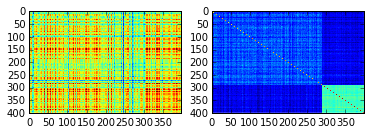

In [11]:
pl.subplot(2,2,1)
pl.imshow(K_foreground,aspect='auto',interpolation='none')
pl.subplot(2,2,2)
pl.imshow(K_background,aspect='auto',interpolation='none')
